# Calculation of energy consumption during training of a PyTorch neural network.

In [11]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

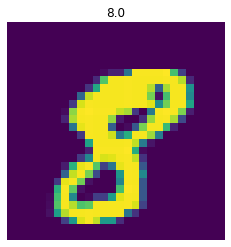

In [21]:
# Prepare Dataset
# load data
train = pd.read_csv(r"/home/psyko/data_science/digit-recognizer/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
#n_iters = 2000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [22]:
# Create ANN Model
class ANNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        
        # Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

# instantiate ANN
input_dim = 28*28
hidden_dim = 150 #hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now I only say 150 there is no reason.
output_dim = 10

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [23]:
# Importing PyJoules library packages
from pyJoules.device.rapl_device import RaplPackageDomain
from pyJoules.handler.pandas_handler import PandasHandler
#from pyJoules.handler.csv_handler import CSVHandler
from pyJoules.energy_meter import EnergyContext

In [24]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
pandas_handler = PandasHandler() 
for epoch in range(num_epochs):

    with EnergyContext(handler=pandas_handler, domains=[RaplPackageDomain(0)]) as ctx:
        for i, (images, labels) in enumerate(train_loader):
        
        

            train = Variable(images.view(-1, 28*28))
            labels = Variable(labels)

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and ross entropy loss
            loss = error(outputs, labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            count += 1

            if count % 50 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Predict test dataset
                for images, labels in test_loader:

                    test = Variable(images.view(-1, 28*28))

                    # Forward propagation
                    outputs = model(test)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # Total number of labels
                    total += len(labels)

                    # Total correct predictions
                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))
    
    # Recovery of training values and energies by epoch
    # An epoch is when all the training data is used at
    # once and is defined as the total number of iterations
    # of all the training data in one cycle for training
    # the machine learning model. 
    df = pandas_handler.get_dataframe()
    df["accuracy"] = pd.Series(accuracy_list)

Iteration: 500  Loss: 0.7791870832443237  Accuracy: 78.44047546386719 %
Iteration: 1000  Loss: 0.4740912616252899  Accuracy: 87.8452377319336 %
Iteration: 1500  Loss: 0.20871113240718842  Accuracy: 89.83333587646484 %
Iteration: 2000  Loss: 0.27471914887428284  Accuracy: 90.79762268066406 %
Iteration: 2500  Loss: 0.31847357749938965  Accuracy: 91.95237731933594 %
Iteration: 3000  Loss: 0.11470475792884827  Accuracy: 92.64286041259766 %
Iteration: 3500  Loss: 0.23890309035778046  Accuracy: 93.36904907226562 %
Iteration: 4000  Loss: 0.06673715263605118  Accuracy: 93.83333587646484 %
Iteration: 4500  Loss: 0.30530938506126404  Accuracy: 94.32142639160156 %
Iteration: 5000  Loss: 0.10148217529058456  Accuracy: 94.66666412353516 %
Iteration: 5500  Loss: 0.20357607305049896  Accuracy: 94.8452377319336 %
Iteration: 6000  Loss: 0.20212267339229584  Accuracy: 95.16666412353516 %
Iteration: 6500  Loss: 0.1011214479804039  Accuracy: 95.32142639160156 %
Iteration: 7000  Loss: 0.11386910080909729  

In [25]:
#DataFrame of energy consumption and accuracy
df.head()

,timestamp,tag,duration,package_0,accuracy
0,1.666261e+09,start,1.978901,24960752.0,tensor(19.6548)
1,1.666261e+09,start,2.204426,27249686.0,tensor(37.4643)
2,1.666261e+09,start,2.078031,25019529.0,tensor(58.5000)
3,1.666261e+09,start,1.852922,23081362.0,tensor(60.3810)
4,1.666261e+09,start,2.073715,25898005.0,tensor(58.9167)


In [34]:
#Number of Sample of dataFrame
print(len(df))

29


29


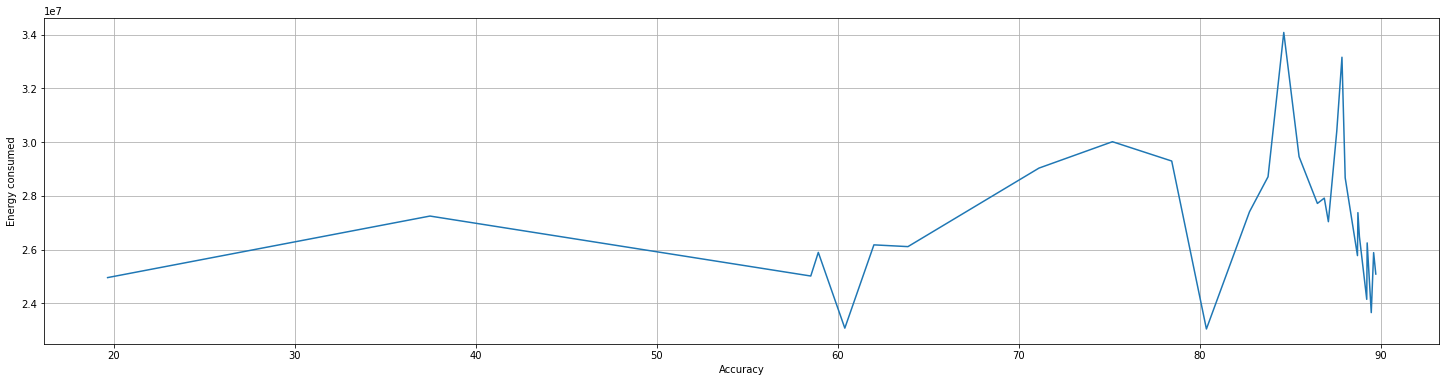

In [33]:
#Plot of Energy consumed by Accuracy
print(len(df))
plt.figure(figsize =(25, 6))
sns.lineplot(x="accuracy", y="package_0", data=df)
plt.xlabel('Accuracy')
plt.ylabel('Energy consumed')
plt.plot(marker = 'o')
plt.grid()

In [35]:
df

,timestamp,tag,duration,package_0,accuracy
0,1.666261e+09,start,1.978901,24960752.0,tensor(19.6548)
1,1.666261e+09,start,2.204426,27249686.0,tensor(37.4643)
2,1.666261e+09,start,2.078031,25019529.0,tensor(58.5000)
3,1.666261e+09,start,1.852922,23081362.0,tensor(60.3810)
4,1.666261e+09,start,2.073715,25898005.0,tensor(58.9167)
5,1.666261e+09,start,2.168860,26178095.0,tensor(61.9881)
6,1.666261e+09,start,2.113661,26113031.0,tensor(63.8690)
7,1.666261e+09,start,2.321522,29033190.0,tensor(71.1071)
8,1.666261e+09,start,2.445880,30014327.0,tensor(75.1667)
9,1.666261e+09,start,2.390156,29296006.0,tensor(78.4405)


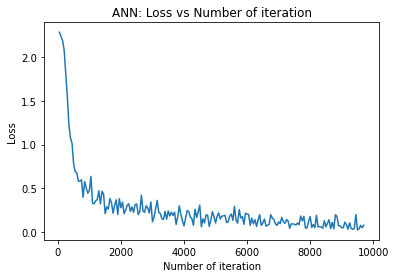

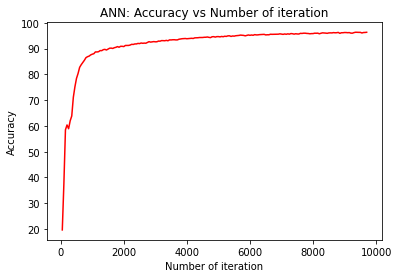

In [36]:
#visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()